### Case Study 1

[Kaggle - dataset description](https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset)

In [238]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import time
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

In [239]:
#Funkcja do wizualizacji macierzy pomyłek i oceny modelu
def cm_results(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_names = ['not fraud', 'fraud']
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.show()

    class_rep=classification_report(y_test, y_pred)
    print(class_rep)

In [240]:
dane=pd.read_csv("../datasets/case1.csv", delimiter=";")
dane=dane.drop(columns=["Unnamed: 0", "Index", "Address"])
y_data=dane[["FLAG"]]
X_data=dane.drop(columns="FLAG")

In [241]:
X_data

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,12635.10,631.39,58748.48,4,13,0,11,4,0.004082,12.000000,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork
9837,0.00,0.00,0.00,0,0,0,0,0,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
9838,2499.44,2189.29,261601.88,67,43,0,31,44,0.001078,21.310000,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com
9839,0.00,0.00,0.00,0,1,0,1,0,0.500000,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [242]:
y_data.value_counts()/y_data.value_counts().sum()

FLAG
0       0.778579
1       0.221421
Name: count, dtype: float64

### Przygotowanie danych

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [244]:
y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)

In [245]:
#oddzielenie danych numerycznych od tekstowych
X_train_num=X_train.iloc[:,:-2]
X_train_text=X_train.iloc[:, -2:]

X_test_num=X_test.iloc[:,:-2]
X_test_text=X_test.iloc[:, -2:]

#### Text processing

In [246]:
#Zamiana wszystkich brakujących wartości na "None"
X_train_text.replace(["0", "", " ", np.nan], "None", inplace=True)
X_test_text.replace(["0",  "", " ", np.nan], "None", inplace=True)

In [247]:
#Braki w kolumnie 'ERC20_most_rec_token_type'
X_train_text.iloc[:, -1].str.contains('None').sum()/X_train_text.shape[0]

0.5356961382113821

Prawie 54% danych w kolumnie 'ERC20_most_rec_token_type' to wartości brakujące.

Pokażemy rozkład liczby występowania poszczególnych typów tokenów ze względu na klasę.

In [248]:
data_0 = X_train_text[y_train['FLAG']==0]['ERC20_most_rec_token_type']
data_1 = X_train_text[y_train['FLAG']==1]['ERC20_most_rec_token_type']

In [249]:
word_freq_0 = data_0.str.split(expand=True).stack().value_counts()
word_freq_1 = data_1.str.split(expand=True).stack().value_counts()
word_freq_sum = X_train_text['ERC20_most_rec_token_type'].str.split(expand=True).stack().value_counts()

word_freq_df = pd.DataFrame({'not_fraud_prob_rec': word_freq_0/data_0.shape[0], 'fraud_prob_rec': word_freq_1/data_1.shape[0], 'fraud_per_occurence_rec': word_freq_1/word_freq_sum}).fillna(0)

word_freq_df = word_freq_df.sort_values(by='not_fraud_prob_rec', ascending=False)

top_20_words = word_freq_df.head(20)
data=top_20_words.reset_index()

In [250]:
transformed_df = pd.melt(data, id_vars=['index'], var_name='is_fraud', value_name='value')
transformed_df['is_fraud'] = transformed_df['is_fraud'].map({'not_fraud_prob_rec': 0, 'fraud_prob_rec': 1})

Text(0.5, 1.0, 'ERC20_most_rec_token_type')

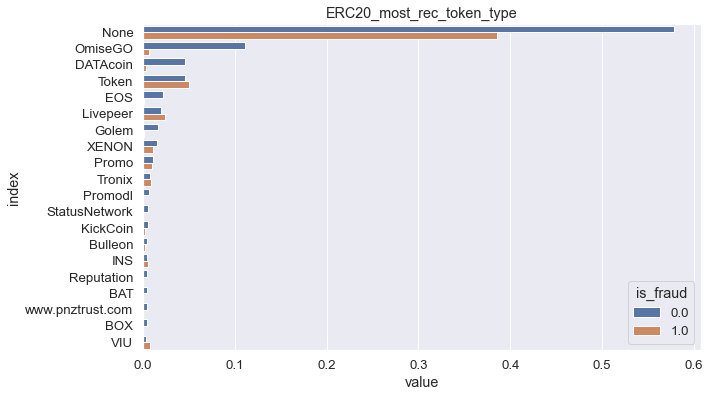

In [251]:
plt.figure(figsize=(10, 6))
sns.barplot(data=transformed_df, y='index', x='value', hue='is_fraud', orient='h') 
plt.title('ERC20_most_rec_token_type')

Ze względu na dużą liczbę braków w 'ERC20_most_rec_token_type', postanowiono, aby nie uzupełniać braków najczęściej występującym tokenem. W wierszach z brakami danych, przestępstwa występują stosunkowo częściej niż dla OmiseGO, więc połączenie tych dwóch kategorii nie byłoby dobrym pomysłem.

Ważne jest jednak, aby uwzględnić tokeny, które wiążą się z wyższym ryzykiem oszustwa. W związku z tym utworzono dla danych tekstowych po dwie nowe zmienne:
- prawdopodobieństwo oszustwa (fraud_prob): liczba wystąpień słowa w oszustwach podzielona przez liczbę wszystkich oszustw
- odstetek oszustw wśród wystąpień danego słowa (fraud_per_occur): liczba wystąpień słowa w oszustwach podzielona przez liczbę wszystkich wystąpień tego słowa

In [252]:
# Braki w kolumnie 'ERC20 most sent token type'
X_train_text.iloc[:, -2].str.contains('None').sum()/X_train_text.shape[0]

0.8407012195121951

Aż 84% danych w kolumnie 'ERC20 most sent token type' to wartości brakujące. Analogicznie przedstawiono liczbę wystąpień różnych tokenów ze względu na klasę i dodano nowe zmienne.

In [253]:
data_2 = X_train_text[y_train['FLAG']==0]['ERC20 most sent token type']
data_3 = X_train_text[y_train['FLAG']==1]['ERC20 most sent token type']

In [254]:
word_freq_2 = data_2.str.split(expand=True).stack().value_counts()
word_freq_3 = data_3.str.split(expand=True).stack().value_counts()
word_freq_sum_2 = X_train_text['ERC20 most sent token type'].str.split(expand=True).stack().value_counts()

word_freq_df2 = pd.DataFrame({'not_fraud_prob_sent': word_freq_2/data_2.shape[0], 'fraud_prob_sent': word_freq_3/data_3.shape[0], 'fraud_per_occurence_sent': word_freq_3/word_freq_sum_2}).fillna(0)

word_freq_df2 = word_freq_df2.sort_values(by='not_fraud_prob_sent', ascending=False)

top_20_words2 = word_freq_df2.head(20)
data2=top_20_words2.reset_index()

In [255]:
transformed_df2 = pd.melt(data2, id_vars=['index'], var_name='is_fraud', value_name='value')
transformed_df2['is_fraud'] = transformed_df2['is_fraud'].map({'not_fraud_prob_sent': 0, 'fraud_prob_sent': 1})

Text(0.5, 1.0, 'ERC20 most sent token type')

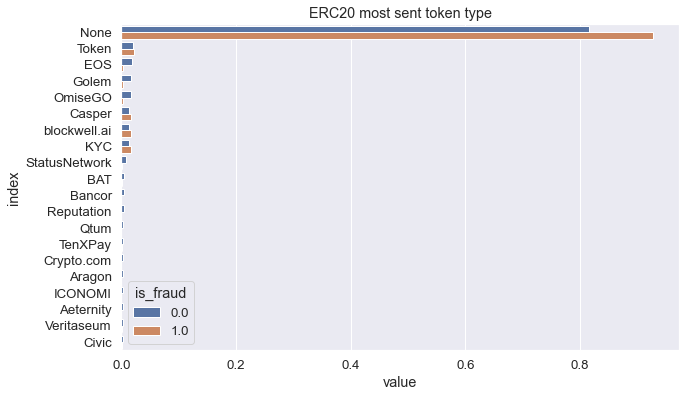

In [256]:
plt.figure(figsize=(10, 6))
sns.barplot(data=transformed_df2, y='index', x='value', hue='is_fraud', orient='h') 
plt.title('ERC20 most sent token type')

Zdecydowana większość oszustw nie ma podanej wartości zmiennej 'ERC20 most sent token type'. Analogicznie, zamiast zastępować braki najczęściej występującą wartością, utworzono nowe zmienne, świadczące o ryzyku wiążącym się z danym słowem.

#### Numeric data processing

In [257]:
#Uzupełnienie brakujących wartości za pomocą metody K najblższych sąsiadów
imputer = KNNImputer(n_neighbors=3)
X_cols=X_train_num.columns

X_train_num_imp = imputer.fit_transform(X_train_num)
X_test_num_imp = imputer.transform(X_test_num)

X_train_num_df = pd.DataFrame(X_train_num_imp, columns=X_cols)
X_test_num_df = pd.DataFrame(X_test_num_imp, columns=X_cols)

In [258]:
#Standaryzacja uzupełnionych danych
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(X_train_num_imp)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=X_cols)

scaled_test_data = scaler.transform(X_test_num_imp)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=X_cols)

#### Dodanie nowych zmiennych


In [259]:
# W przypadku braków danych zakładamy ryzyko oszustwa równe 50%
word_freq_df.loc["None"]=[0.5, 0.5, 0.5]
word_freq_df2.loc["None"]=[0.5, 0.5, 0.5]

In [260]:
#doklejamy nowe kolumny do danych tekstowych
new_columns = pd.merge(X_train_text, 
                       word_freq_df[['fraud_prob_rec', 'fraud_per_occurence_rec']], 
                       how='left', 
                       left_on='ERC20_most_rec_token_type', 
                       right_on=word_freq_df.index).fillna(0)

new_columns2 = pd.merge(new_columns, 
                       word_freq_df2[['fraud_prob_sent', 'fraud_per_occurence_sent']], 
                       how='left', 
                       left_on='ERC20 most sent token type', 
                       right_on=word_freq_df2.index).fillna(0)
new_columns3=new_columns2.iloc[:, 2:]         

new_columns_test = pd.merge(X_test_text, 
                       word_freq_df[['fraud_prob_rec', 'fraud_per_occurence_rec']], 
                       how='left', 
                       left_on='ERC20_most_rec_token_type', 
                       right_on=word_freq_df.index).fillna(0)

new_columns2_test = pd.merge(new_columns_test, 
                       word_freq_df2[['fraud_prob_sent', 'fraud_per_occurence_sent']], 
                       how='left', 
                       left_on='ERC20 most sent token type', 
                       right_on=word_freq_df2.index).fillna(0)
new_columns3_test=new_columns2_test.iloc[:, 2:]  

In [261]:
#Złączenie danych zestandaryzowanych z nowo utworzonymi zmiennymi
combined_X_train_data_std = pd.concat([scaled_train_df, new_columns3], axis=1)
combined_X_test_data_std= pd.concat([scaled_test_df, new_columns3_test], axis=1)

#### Boxploty dla wszystkich zmiennych

In [262]:
train_df2=pd.concat([y_train, combined_X_train_data_std], axis=1)
fig = px.box(train_df2, color="FLAG")
fig.update_layout(xaxis_title="Nr zmiennej",
                  yaxis_title="Wartość zestandaryzowana")
fig.write_html("boxplot_alldata.html") 
#ze względu na wielkość, wykres należy pobrać i otworzyć w przeglądarce, ponieważ w notebooku jest mało czytelny

Na podstawie boxplotów, możemy zauważyć, że jest bardzo dużo wartości odstających. Zdecydowano jednak, aby ich nie usuwać, ponieważ znacznie zmniejszyłoby to zbiór danych. Ponadto, skoro charakterystyka zmiennych treningowych pokazuje, że mają one tak dużą zmienność, to dane testowe najprawdopodobniej też będą się tym charakteryzować.

### Wybór modelu do klasyfikacji

In [263]:
A=3
B=1
weights={ 0: B, 1: A}

models = {
    'RandomForest': RandomForestClassifier(n_estimators= 100, min_samples_split= 5, min_samples_leaf= 1),
    'XGBoost': xgb.XGBClassifier(),
    'KNN5': KNeighborsClassifier(n_neighbors=5),
    'KNN10': KNeighborsClassifier(n_neighbors=10),
    'LogisticRegression': LogisticRegression(),
    'LogisticRegression_weigths': LogisticRegression(solver='lbfgs', class_weight=weights),
    'SVM': SVC()
}

results = pd.DataFrame(columns=['Model', 'ROC-AUC', 'Czas wykonywania'])

for model_name, model in models.items():

        start=time.time()
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(model, combined_X_train_data_std,  y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
        czas=time.time()-start

        result_row ={
            'Model': model_name,
            'ROC-AUC': np.mean(scores),
            'Czas wykonywania': czas
        }

        results=pd.concat([results, pd.DataFrame([result_row])], ignore_index=True)

C:\Users\dorot\AppData\Local\Temp\ipykernel_54624\1425374319.py:30: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [264]:
results

,Model,ROC-AUC,Czas wykonywania
0,RandomForest,0.992729,7.692249
1,XGBoost,0.995499,2.248485
2,KNN5,0.956044,0.584042
3,KNN10,0.962251,0.460592
4,LogisticRegression,0.881227,0.944968
5,LogisticRegression_weigths,0.886287,1.081973
6,SVM,0.875008,15.472454


### XGBoost

In [265]:
combined_X_train_data_std.shape

(7872, 49)

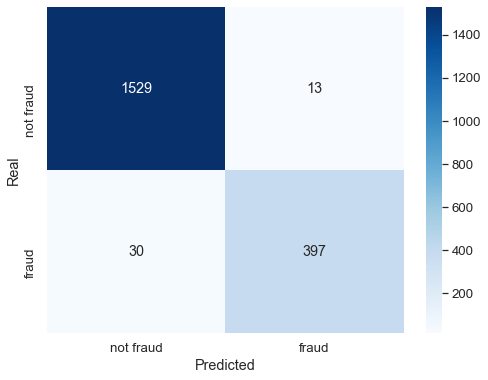

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1542
           1       0.97      0.93      0.95       427

    accuracy                           0.98      1969
   macro avg       0.97      0.96      0.97      1969
weighted avg       0.98      0.98      0.98      1969



In [266]:
clf = xgb.XGBClassifier(tree_method="hist")

clf.fit(combined_X_train_data_std, y_train)
y_pred = clf.predict(combined_X_test_data_std)
cm_results(y_test, y_pred)

30 razy nie wykryto przestępstwa.

### Klasyfikacja na podstawie zmiennych z PCA bez resamplingu

In [268]:
pca = PCA(n_components=0.98)
X_train_pca = pca.fit_transform(combined_X_train_data_std)
X_test_pca = pca.transform(combined_X_test_data_std)

print("Liczba:", pca.n_components_)
print("Procent wariancji:", np.sum(pca.explained_variance_ratio_))

Liczba: 25
Procent wariancji: 0.9824025502728044


Możemy zmniejszyć liczbę zmiennych z 45 do 25 zachowując przy tym 98% wariancji.

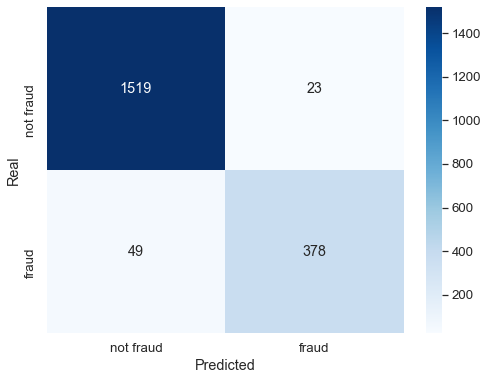

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1542
           1       0.94      0.89      0.91       427

    accuracy                           0.96      1969
   macro avg       0.96      0.94      0.94      1969
weighted avg       0.96      0.96      0.96      1969



In [269]:
model_xgb = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
model_xgb.fit(X_train_pca,  y_train)
y_pred=model_xgb.predict(X_test_pca)
cm_results(y_test, y_pred)

Ze względu na częściową utatę danych, to liczba FP i FN pogorszyła się. W związku z tym, że czas obliczeń nie jest długi, postanowiono, aby pozostać przy zmiennych bez transormacji PCA.

### Klasyfikacja na podstawie kolumn numerycznych z resamplingiem

#### Resampling

In [270]:
y_train.value_counts()

FLAG
0       6120
1       1752
Name: count, dtype: int64

In [271]:
#Dodatkowe wiersze
smote = SMOTE(random_state=42, sampling_strategy=0.4)
X_smote, y_smote = smote.fit_resample(combined_X_train_data_std, y_train)
y_smote.value_counts()

FLAG
0       6120
1       2448
Name: count, dtype: int64

In [272]:
#UnderSampling
rus=RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled =rus.fit_resample(X_smote, y_smote)
print(y_resampled .value_counts())

FLAG
0       4080
1       2448
Name: count, dtype: int64


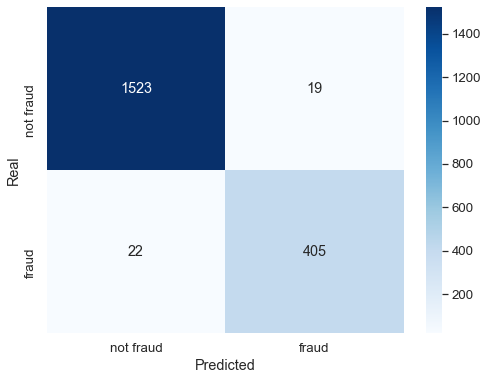

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1542
           1       0.96      0.95      0.95       427

    accuracy                           0.98      1969
   macro avg       0.97      0.97      0.97      1969
weighted avg       0.98      0.98      0.98      1969



In [273]:
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
clf.fit(X_resampled, y_resampled)
y_pred = clf.predict(combined_X_test_data_std)
cm_results(y_test, y_pred)

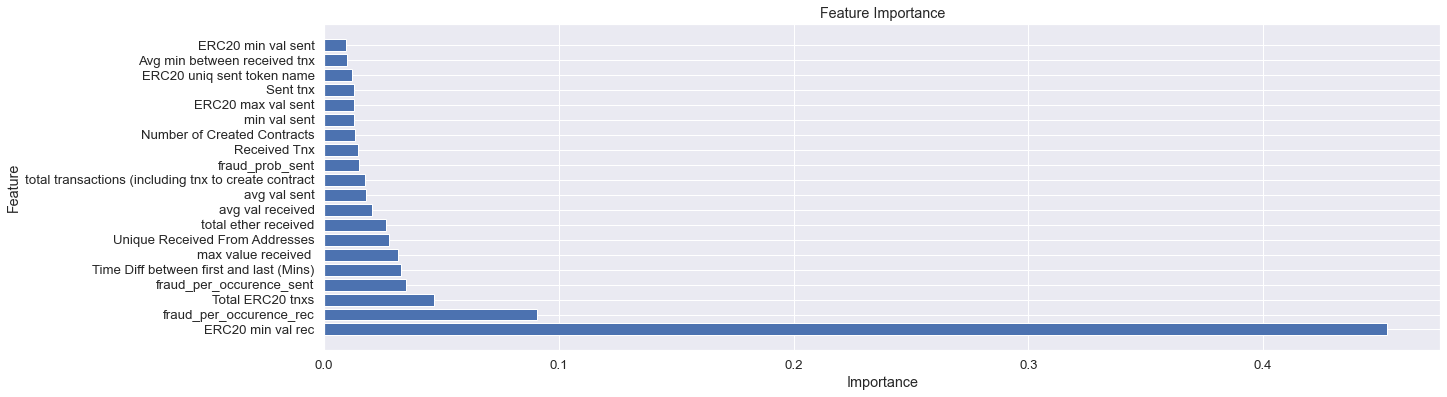

In [274]:
model=clf
importance = model.feature_importances_

feature_names = combined_X_train_data_std.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Resampling pozwolił zmniejszyć liczbę FN do 22. Najbardziej znaczącą zmienną jest 'ERC20 min val rec'.